# Plots

_Note_: If you want to ensure your figure aesthetics are the same, either manually configure the `rc` variable in the first cell or place these lines in your `~/.config/matplotlib/matplotlibrc` file:

    lines.linewidth: 2
    lines.markeredgecolor: k
    lines.markeredgewidth: 1.3
    boxplot.whiskers: 1.5
    boxplot.patchartist: True
    boxplot.showmeans: True
    boxplot.meanline: False
    boxplot.boxprops.linewidth: 1.5
    boxplot.whiskerprops.linewidth: 1.5
    boxplot.medianprops.linewidth: 1.5
    boxplot.medianprops.color: None
    boxplot.meanprops.marker: ^
    boxplot.meanprops.markerfacecolor: w
    boxplot.meanprops.markeredgecolor: k
    axes.grid: True
    axes.linewidth: 1.5
    xtick.bottom: True
    xtick.labelbottom: True
    xtick.major.width: 1.5
    xtick.minor.width: 1 
    ytick.left: True
    ytick.labelleft: True
    ytick.major.width: 1.5
    ytick.minor.width: 1 
    grid.linestyle: --
    hist.bins: auto  
    savefig.bbox: tight

In [1]:
from pathlib import Path
from typing import Iterable, Union

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

ROGI_KEY = "rogi"
CSV_DIR = Path("./results/raw/rogi/tdc+guac")
JSON_DIR = Path("../results/raw/cv/tdc+guac/")

In [2]:
def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]

    vals = set(vals)
    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()

    for line in gridlines:
        val = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if val in vals:
            line.set_visible(False)
    
    return ax


def rogi_string(x: str):
    return rf"$\mathrm{{ROGI}}_{{\mathrm{{{x}}}}}$"

In [3]:
df = pd.concat(map(pd.read_json, JSON_DIR.iterdir()), ignore_index=True)\
    .groupby(["features", "dataset_and_task"])\
    .agg({"n_valid": "mean", "rogi": ["mean", "std", "count"]})\
    .reset_index()

FEATURES = df["features"].unique()
FEATURE_LABELS = dict(vae="VAE", gin="GIN", chemberta="ChemBERTa", chemgpt="ChemGPT")
FEATURE_COLORS = sns.color_palette("Set2", len(FEATURES))

df

features         dataset_and_task  n_valid      rogi           
                                           mean      mean  std count
0   chemberta  ARIPIPRAZOLE_SIMILARITY  10000.0  0.158179  0.0     5
1   chemberta               CACO2_WANG    910.0  0.217590  0.0     5
2   chemberta    CELECOXIB_REDISCOVERY  10000.0  0.156523  0.0     5
3   chemberta  CLEARANCE_HEPATOCYTE_AZ   1213.0  0.446076  0.0     5
4   chemberta   CLEARANCE_MICROSOME_AZ   1102.0  0.369319  0.0     5
..        ...                      ...      ...       ...  ...   ...
85        vae                  PPBR_AZ   1614.0  0.211631  0.0     5
86        vae             SCAFFOLD HOP  10000.0  0.114315  0.0     5
87        vae       SOLUBILITY_AQSOLDB   9982.0  0.140727  0.0     5
88        vae            VDSS_LOMBARDO   1130.0  0.049120  0.0     5
89        vae             ZALEPLON_MPO  10000.0  0.264489  0.0     5

[90 rows x 6 columns]

## ROGI distribution boxplot

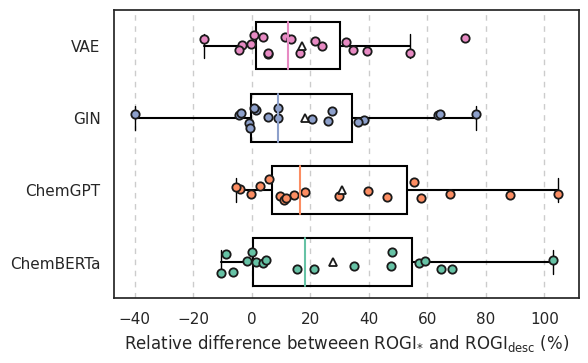

In [ ]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1, 1, figsize=(6, len(FEATURES) * 0.75))

JITTER = 0.15
BUFFER = 3

x = df[df['features'] == "descriptor"]['rogi']['mean'].values
ys = [df[df['features'] == f]['rogi']['mean'].values for f in FEATURES if f != "descriptor"]
Z = np.array(ys) / x - 1
Z *= 100

ax.boxplot(
    Z.T,
    vert=False,
    labels=[FEATURE_LABELS[f] for f in FEATURES if f != "descriptor"],
    widths=0.66,
    showmeans=True,
    patch_artist=True,
    boxprops=dict(fc="None"),
    medianprops=dict(c=None),
    showfliers=False,
)

ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))

for j in range(len(Z)):
    z = Z[j]
    y = (j + 1) + np.random.uniform(-JITTER, JITTER, z.shape)

    ax.plot(z, y, 'o', color=FEATURE_COLORS[j])

ax.set_xlabel(f"Relative difference betweeen {rogi_string('*')} and {rogi_string('desc')} (%)")
ax.grid(False, axis='y')


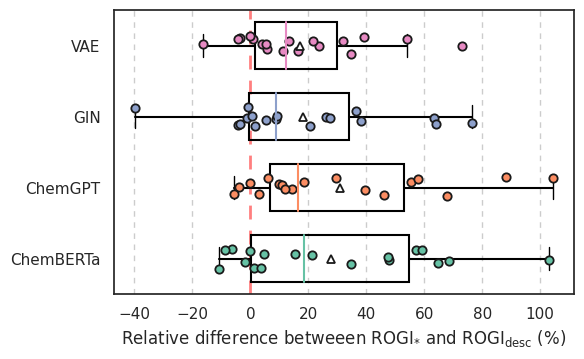

In [ ]:
disable_gridlines(ax, "x", [0])
ax.axvline(0, ls="--", color="red", dashes=(5, 4), zorder=-10, alpha=0.5)

fig.tight_layout()
fig

In [ ]:
fig.savefig("../results/figures/rogi-boxplot-v2.pdf", bbox_inches="tight")

## Parity plots

In [4]:
def parity_plot(
    ax: plt.Axes, df: pd.DataFrame, x_key: str, y_key: str, threshold: float = 0.1
):
    x = df.loc[x_key.lower()]["rogi"]['mean']
    y = df.loc[y_key.lower()]["rogi"]['mean']
    s = df.loc[x_key.lower()]["n_valid"]['mean'].values / 1e2
    z = (y - x) / x

    ax.scatter(x, y, s, z, vmin=-1, vmax=1, cmap="coolwarm", edgecolors='k', lw=1.3)
    ax.plot([[0, 0], [1, 1]], '--', c='grey', dashes=(4, 2.5), zorder=-1)

    roughest_dset = z.idxmax()
    i = z.index.get_loc(roughest_dset)
    # arrowprops = dict(arrowstyle="-|>,width=1", facecolor='black')
    arrowprops = dict(width=2.5, headwidth=10, shrink=0.2, facecolor='k')
    ax.annotate(
        roughest_dset,
        (x[i], y[i]),
        (0.225, 0.45),
        textcoords='data',
        ha="center",
        arrowprops=arrowprops,
        fontsize=10
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(y_key)

In [ ]:
desc_key = "descriptor"
features = ["VAE", "GIN", "ChemBERTa", "ChemGPT"]
N = len(features)
fig, axs = plt.subplots(1, N, figsize=(3.5 * N, 4), sharex=True, sharey=True)

for i in range(len(features)):
    ax = axs[i]
    feature = features[i]
    parity_plot(ax, df, desc_key, feature, 0.10)
    if i == 0:
        ax.set_ylabel("ROGI")

fig.supxlabel(rogi_string(desc_key))
fig.tight_layout()

In [22]:
fig.savefig(f"./results/figures/{'-'.join(features)}.pdf", bbox_inches="tight")